# 9.3 Optimising with Cython

*Estimated time for this notebook: 20 minutes*

Cython can be viewed as an extension of Python where variables and functions are annotated with extra information, in particular types. The resulting Cython source code will be compiled into optimized C or C++ code, and thereby yielding substantial speed-up of slow Python code. In other words, Cython provides a way of writing Python with comparable performance to that of C/C++.

## Start coding in Cython

Cython code must, unlike Python, be compiled. This happens in the following stages:

* The cython code in `.pyx` file will be translated to a `C` file.
* The `C` file will be compiled by a C compiler into a shared library, which will be directly loaded into Python. 

In a Jupyter notebook, everything is a lot easier. One needs only to load the Cython extension (`%load_ext Cython`) at the beginning and put `%%cython` mark in front of cells of Cython code. Cells with Cython mark will be treated as a `.pyx` code and consequently, compiled into C. 

For details, please see [Building Cython Code](http://docs.cython.org/src/quickstart/build.html).


### Pure python Mandelbrot set:

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + (xmax - xmin) * i / resolution) for i in range(resolution)]
ys = [(ymin + (ymax - ymin) * i / resolution) for i in range(resolution)]

In [2]:
def mandel(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

### Compiled by Cython:

In [3]:
%load_ext Cython

In [4]:
%%cython

def mandel_cython(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value ** 2 + position
        if limit < 0:
            return 0
    return limit

Let's verify the result

In [5]:
data_python = [[mandel(complex(x, y)) for x in xs] for y in ys]
data_cython = [[mandel_cython(complex(x, y)) for x in xs] for y in ys]

Text(0.5, 1.0, 'Cython')

<Figure size 640x480 with 0 Axes>

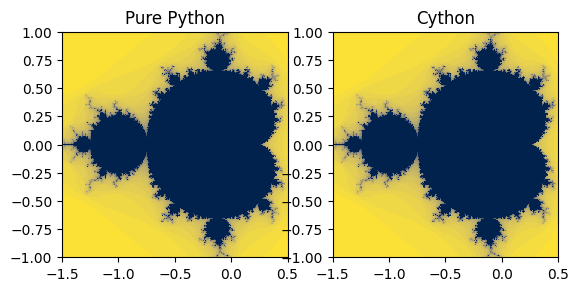

In [6]:
from matplotlib import pyplot as plt

plt.set_cmap("cividis")  # use a CVD-friendly palette

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data_python, interpolation="none", extent=[xmin, xmax, ymin, ymax])
axarr[0].set_title("Pure Python")
axarr[1].imshow(data_cython, interpolation="none", extent=[xmin, xmax, ymin, ymax])
axarr[1].set_title("Cython")

In [7]:
%timeit [[mandel(complex(x,y)) for x in xs] for y in ys] # pure python
%timeit [[mandel_cython(complex(x,y)) for x in xs] for y in ys] # cython

547 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


396 ms ± 4.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We have improved the performance of a factor of 1.5 by just using the Cython compiler, **without changing the code**!

### Cython with C Types
But we can do better by telling Cython what C data type we would use in the code. Note we're not actually writing C, we're writing Python with C types.

_typed variable_

In [8]:
%%cython
def var_typed_mandel_cython(position, limit=50):
    cdef double complex value # typed variable
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

_typed function + typed variable_

In [9]:
%%cython
cpdef call_typed_mandel_cython(double complex position, int limit=50): # typed function
    cdef double complex value # typed variable
    value = position
    while abs(value)<2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

performance of one number:

In [10]:
# pure python
%timeit a = mandel(complex(0, 0))

13.1 µs ± 1.98 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
# primitive cython
%timeit a = mandel_cython(complex(0, 0))

9.42 µs ± 19.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
# cython with C type variable
%timeit a = var_typed_mandel_cython(complex(0, 0))

3.22 µs ± 4.38 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
# cython with typed variable + function
%timeit a = call_typed_mandel_cython(complex(0, 0))

583 ns ± 1.76 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Cython with numpy ndarray
You can use NumPy from Cython exactly the same as in regular Python, but by doing so you are losing potentially high speedups because Cython has support for fast access to NumPy arrays. 

In [14]:
import numpy as np

ymatrix, xmatrix = np.mgrid[ymin:ymax:ystep, xmin:xmax:xstep]
values = xmatrix + 1j * ymatrix

In [15]:
%%cython
import numpy as np
cimport numpy as np 

cpdef numpy_cython_1(np.ndarray[double complex, ndim=2] position, int limit=50): 
    cdef np.ndarray[long,ndim=2] diverged_at
    cdef double complex value
    cdef int xlim
    cdef int ylim
    cdef double complex pos
    cdef int steps
    cdef int x, y

    xlim = position.shape[1]
    ylim = position.shape[0]
    diverged_at = np.zeros([ylim, xlim], dtype=int)
    for x in xrange(xlim):
        for y in xrange(ylim):
            steps = limit
            value = position[y,x]
            pos = position[y,x]
            while abs(value) < 2 and steps >= 0:
                steps -= 1
                value = value**2 + pos
            diverged_at[y,x] = steps
  
    return diverged_at

Note the double import of numpy: the standard numpy module and a Cython-enabled version of numpy that ensures fast indexing of and other operations on arrays. **Both import statements are necessary** in code that uses numpy arrays. The new thing in the code above is declaration of arrays by np.ndarray.

In [16]:
%timeit data_python = [mandel(value) for row in values for value in row] # pure python

596 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit data_cython = [call_typed_mandel_cython(value) for row in values for value in row] # typed cython

34.2 ms ± 25.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit data_numpy_cython = numpy_cython_1(values) # ndarray

25.4 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


`numpy` has a built-in function called `np.vectorize` to take a function that runs on a single object and return a function that runs on arrays of that object.
Note that this is no faster than explicitly writing the vectorised version of the function yourself, as we can see below.

In [19]:
numpy_cython_2 = np.vectorize(call_typed_mandel_cython)

In [20]:
%timeit numpy_cython_2(values) #  vectorize

33 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We got approximately a 40x total speed up from `mandel` to `numpy_cython_1`.

### Calling C functions from Cython

#### Example: compare `sin()` from Python and C library

In [21]:
%%cython
import math
cpdef py_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = math.sin(x)

In [22]:
%%cython
from libc.math cimport sin as csin # import from C library
cpdef c_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = csin(x)

In [23]:
%timeit [math.sin(i) for i in range(int(1e7))] # python

1.66 s ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit py_sin()                                # cython call python library

1.01 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit c_sin()                                 # cython call C library

5.17 ms ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
